In [ ]:
!pip install scikit-fuzzy

     |████████████████████████████████| 993 kB 4.0 MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894089 sha256=16832eeec93ddc71001a2e70ce2faadd802e934c3acb4db3273f7ff5a60c2544
  Stored in directory: /root/.cache/pip/wheels/d5/74/fc/38588a3d2e3f34f74588e6daa3aa5b0a322bd6f9420a707131
Successfully built scikit-fuzzy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np

In [ ]:
from skfuzzy import gaussmf, gbellmf, sigmf

class MemFuncs:
    'Common base class for all employees'
    funcDict = {'gaussmf': gaussmf, 'gbellmf': gbellmf, 'sigmf': sigmf}


    def __init__(self, MFList):
        self.MFList = MFList

    def evaluateMF(self, rowInput):
        if len(rowInput) != len(self.MFList):
            print("Number of variables does not match number of rule sets")

        return [[self.funcDict[self.MFList[i][k][0]](rowInput[i],**self.MFList[i][k][1]) for k in range(len(self.MFList[i]))] for i in range(len(rowInput))]


In [ ]:
def partial_dMF(x, mf_definition, partial_parameter):
    """Calculates the partial derivative of a membership function at a point x.
    Parameters
    ------
    Returns
    ------
    """
    mf_name = mf_definition[0]

    if mf_name == 'gaussmf':

        sigma = mf_definition[1]['sigma']
        mean = mf_definition[1]['mean']

        if partial_parameter == 'sigma':
            result = (2./sigma**3) * np.exp(-(((x-mean)**2)/(sigma)**2))*(x-mean)**2
        elif partial_parameter == 'mean':
            result = (2./sigma**2) * np.exp(-(((x-mean)**2)/(sigma)**2))*(x-mean)

    elif mf_name == 'gbellmf':

        a = mf_definition[1]['a']
        b = mf_definition[1]['b']
        c = mf_definition[1]['c']

        if partial_parameter == 'a':
            result = (2. * b * np.power((c-x),2) * np.power(np.absolute((c-x)/a), ((2 * b) - 2))) / \
                (np.power(a, 3) * np.power((np.power(np.absolute((c-x)/a),(2*b)) + 1), 2))
        elif partial_parameter == 'b':
            result = -1 * (2 * np.power(np.absolute((c-x)/a), (2 * b)) * np.log(np.absolute((c-x)/a))) / \
                (np.power((np.power(np.absolute((c-x)/a), (2 * b)) + 1), 2))
        elif partial_parameter == 'c':
            result = (2. * b * (c-x) * np.power(np.absolute((c-x)/a), ((2 * b) - 2))) / \
                (np.power(a, 2) * np.power((np.power(np.absolute((c-x)/a),(2*b)) + 1), 2))

    elif mf_name == 'sigmf':

        b = mf_definition[1]['b']
        c = mf_definition[1]['c']

        if partial_parameter == 'b':
            result = -1 * (c * np.exp(c * (b + x))) / \
                np.power((np.exp(b*c) + np.exp(c*x)), 2)
        elif partial_parameter == 'c':
            result = ((x - b) * np.exp(c * (x - b))) / \
                np.power((np.exp(c * (x - c))) + 1, 2)


    return result

In [ ]:
import itertools
import copy

class ANFIS:
    """Class to implement an Adaptive Network Fuzzy Inference System: ANFIS"
    Attributes:
        X
        Y
        XLen
        memClass
        memFuncs
        memFuncsByVariable
        rules
        consequents
        errors
        memFuncsHomo
        trainingType
    """

    def __init__(self, X, Y, memFunction):
        self.X = np.array(copy.copy(X))
        self.Y = np.array(copy.copy(Y))
        self.XLen = len(self.X)
        self.memClass = copy.deepcopy(memFunction)
        self.memFuncs = self.memClass.MFList
        self.memFuncsByVariable = [[x for x in range(len(self.memFuncs[z]))] for z in range(len(self.memFuncs))]
        self.rules = np.array(list(itertools.product(*self.memFuncsByVariable)))
        self.consequents = np.empty(self.Y.ndim * len(self.rules) * (self.X.shape[1] + 1))
        self.consequents.fill(0)
        self.errors = np.empty(0)
        self.memFuncsHomo = all(len(i)==len(self.memFuncsByVariable[0]) for i in self.memFuncsByVariable)
        self.trainingType = 'Not trained yet'

    def LSE(self, A, B, initialGamma = 1000.):
        coeffMat = A
        rhsMat = B
        S = np.eye(coeffMat.shape[1])*initialGamma
        x = np.zeros((coeffMat.shape[1],1)) # need to correct for multi-dim B
        for i in range(len(coeffMat[:,0])):
            a = coeffMat[i,:]
            b = np.array(rhsMat[i])
            S = S - (np.array(np.dot(np.dot(np.dot(S,np.matrix(a).transpose()),np.matrix(a)),S)))/(1+(np.dot(np.dot(S,a),a)))
            x = x + (np.dot(S,np.dot(np.matrix(a).transpose(),(np.matrix(b)-np.dot(np.matrix(a),x)))))
        return x

    def trainHybridJangOffLine(self, epochs=5, tolerance=1e-5, initialGamma=1000, k=0.01):

        self.trainingType = 'trainHybridJangOffLine'
        convergence = False
        epoch = 1

        while (epoch < epochs) and (convergence is not True):

            #layer four: forward pass
            [layerFour, wSum, w] = forwardHalfPass(self, self.X)

            #layer five: least squares estimate
            layerFive = np.array(self.LSE(layerFour,self.Y,initialGamma))
            self.consequents = layerFive
            layerFive = np.dot(layerFour,layerFive)

            #error
            error = np.sum((self.Y-layerFive.T)**2)
            print('current error: '+ str(error))
            average_error = np.average(np.absolute(self.Y-layerFive.T))
            self.errors = np.append(self.errors,error)

            if len(self.errors) != 0:
                if self.errors[len(self.errors)-1] < tolerance:
                    convergence = True

            # back propagation
            if convergence is not True:
                cols = range(len(self.X[0,:]))
                dE_dAlpha = list(backprop(self, colX, cols, wSum, w, layerFive) for colX in range(self.X.shape[1]))


            if len(self.errors) >= 4:
                if (self.errors[-4] > self.errors[-3] > self.errors[-2] > self.errors[-1]):
                    k = k * 1.1

            if len(self.errors) >= 5:
                if (self.errors[-1] < self.errors[-2]) and (self.errors[-3] < self.errors[-2]) and (self.errors[-3] < self.errors[-4]) and (self.errors[-5] > self.errors[-4]):
                    k = k * 0.9

            ## handling of variables with a different number of MFs
            t = []
            for x in range(len(dE_dAlpha)):
                for y in range(len(dE_dAlpha[x])):
                    for z in range(len(dE_dAlpha[x][y])):
                        t.append(dE_dAlpha[x][y][z])

            eta = k / np.abs(np.sum(t))

            if(np.isinf(eta)):
                eta = k

            ## handling of variables with a different number of MFs
            dAlpha = copy.deepcopy(dE_dAlpha)
            if not(self.memFuncsHomo):
                for x in range(len(dE_dAlpha)):
                    for y in range(len(dE_dAlpha[x])):
                        for z in range(len(dE_dAlpha[x][y])):
                            dAlpha[x][y][z] = -eta * dE_dAlpha[x][y][z]
            else:
                dAlpha = -eta * np.array(dE_dAlpha)


            for varsWithMemFuncs in range(len(self.memFuncs)):
                for MFs in range(len(self.memFuncsByVariable[varsWithMemFuncs])):
                    paramList = sorted(self.memFuncs[varsWithMemFuncs][MFs][1])
                    for param in range(len(paramList)):
                        self.memFuncs[varsWithMemFuncs][MFs][1][paramList[param]] = self.memFuncs[varsWithMemFuncs][MFs][1][paramList[param]] + dAlpha[varsWithMemFuncs][MFs][param]
            epoch = epoch + 1


        self.fittedValues = predict(self,self.X)
        self.residuals = self.Y - self.fittedValues[:,0]

        return self.fittedValues


    def plotErrors(self):
        if self.trainingType == 'Not trained yet':
            print(self.trainingType)
        else:
            import matplotlib.pyplot as plt
            plt.plot(range(len(self.errors)),self.errors,'ro', label='errors')
            plt.ylabel('error')
            plt.xlabel('epoch')
            plt.show()

    def plotMF(self, x, inputVar):
        import matplotlib.pyplot as plt
        from skfuzzy import gaussmf, gbellmf, sigmf

        for mf in range(len(self.memFuncs[inputVar])):
            if self.memFuncs[inputVar][mf][0] == 'gaussmf':
                y = gaussmf(x,**self.memClass.MFList[inputVar][mf][1])
            elif self.memFuncs[inputVar][mf][0] == 'gbellmf':
                y = gbellmf(x,**self.memClass.MFList[inputVar][mf][1])
            elif self.memFuncs[inputVar][mf][0] == 'sigmf':
                y = sigmf(x,**self.memClass.MFList[inputVar][mf][1])

            plt.plot(x,y,'r')

        plt.show()

    def plotResults(self):
        if self.trainingType == 'Not trained yet':
            print(self.trainingType)
        else:
            import matplotlib.pyplot as plt
            plt.plot(range(len(self.fittedValues)),self.fittedValues,'r', label='trained')
            plt.plot(range(len(self.Y)),self.Y,'b', label='original')
            plt.legend(loc='upper left')
            plt.show()



def forwardHalfPass(ANFISObj, Xs):
    layerFour = np.empty(0,)
    wSum = []

    for pattern in range(len(Xs[:,0])):
        #layer one
        layerOne = ANFISObj.memClass.evaluateMF(Xs[pattern,:])

        #layer two
        miAlloc = [[layerOne[x][ANFISObj.rules[row][x]] for x in range(len(ANFISObj.rules[0]))] for row in range(len(ANFISObj.rules))]
        layerTwo = np.array([np.product(x) for x in miAlloc]).T
        if pattern == 0:
            w = layerTwo
        else:
            w = np.vstack((w,layerTwo))

        #layer three
        wSum.append(np.sum(layerTwo))
        if pattern == 0:
            wNormalized = layerTwo/wSum[pattern]
        else:
            wNormalized = np.vstack((wNormalized,layerTwo/wSum[pattern]))

        #prep for layer four (bit of a hack)
        layerThree = layerTwo/wSum[pattern]
        rowHolder = np.concatenate([x*np.append(Xs[pattern,:],1) for x in layerThree])
        layerFour = np.append(layerFour,rowHolder)

    w = w.T
    wNormalized = wNormalized.T

    layerFour = np.array(np.array_split(layerFour,pattern + 1))

    return layerFour, wSum, w


def backprop(ANFISObj, columnX, columns, theWSum, theW, theLayerFive):

    paramGrp = [0]* len(ANFISObj.memFuncs[columnX])
    for MF in range(len(ANFISObj.memFuncs[columnX])):

        parameters = np.empty(len(ANFISObj.memFuncs[columnX][MF][1]))
        timesThru = 0
        for alpha in sorted(ANFISObj.memFuncs[columnX][MF][1].keys()):

            bucket3 = np.empty(len(ANFISObj.X))
            for rowX in range(len(ANFISObj.X)):
                varToTest = ANFISObj.X[rowX,columnX]
                tmpRow = np.empty(len(ANFISObj.memFuncs))
                tmpRow.fill(varToTest)

                bucket2 = np.empty(ANFISObj.Y.ndim)
                for colY in range(ANFISObj.Y.ndim):

                    rulesWithAlpha = np.array(np.where(ANFISObj.rules[:,columnX]==MF))[0]
                    adjCols = np.delete(columns,columnX)

                    senSit = partial_dMF(ANFISObj.X[rowX,columnX],ANFISObj.memFuncs[columnX][MF],alpha)
                    # produces d_ruleOutput/d_parameterWithinMF
                    dW_dAplha = senSit * np.array([np.prod([ANFISObj.memClass.evaluateMF(tmpRow)[c][ANFISObj.rules[r][c]] for c in adjCols]) for r in rulesWithAlpha])

                    bucket1 = np.empty(len(ANFISObj.rules[:,0]))
                    for consequent in range(len(ANFISObj.rules[:,0])):
                        fConsequent = np.dot(np.append(ANFISObj.X[rowX,:],1.),ANFISObj.consequents[((ANFISObj.X.shape[1] + 1) * consequent):(((ANFISObj.X.shape[1] + 1) * consequent) + (ANFISObj.X.shape[1] + 1)),colY])
                        acum = 0
                        if consequent in rulesWithAlpha:
                            acum = dW_dAplha[np.where(rulesWithAlpha==consequent)] * theWSum[rowX]

                        acum = acum - theW[consequent,rowX] * np.sum(dW_dAplha)
                        acum = acum / theWSum[rowX]**2
                        bucket1[consequent] = fConsequent * acum

                    sum1 = np.sum(bucket1)

                    if ANFISObj.Y.ndim == 1:
                        bucket2[colY] = sum1 * (ANFISObj.Y[rowX]-theLayerFive[rowX,colY])*(-2)
                    else:
                        bucket2[colY] = sum1 * (ANFISObj.Y[rowX,colY]-theLayerFive[rowX,colY])*(-2)

                sum2 = np.sum(bucket2)
                bucket3[rowX] = sum2

            sum3 = np.sum(bucket3)
            parameters[timesThru] = sum3
            timesThru = timesThru + 1

        paramGrp[MF] = parameters

    return paramGrp


def predict(ANFISObj, varsToTest):

    [layerFour, wSum, w] = forwardHalfPass(ANFISObj, varsToTest)

    #layer five
    layerFive = np.dot(layerFour,ANFISObj.consequents)

    return layerFive



In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Đồ án 2/pima-indians-diabetes.csv")#numpy.loadtxt('c:\\Python_fiddling\\myProject\\MF\\trainingSet.txt',usecols=[1,2,3])
X = df[['Age','Pregnancies']].to_numpy()
Y = df['Outcome'].to_numpy()
print(X)
print(Y)

[[50  6]
 [31  1]
 [32  8]
 ...
 [30  5]
 [47  1]
 [23  1]]
[1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0
 1 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1
 1 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0
 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1
 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0
 1 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0
 1 0 1 0 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 0 0 0 1
 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 1 0 0 1 0 0 1 0 0 1
 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0 1
 0 1 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1
 1 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0

current error: 143.59932251275967
current error: 143.5999789908142
current error: 143.60060177836203
current error: 143.60119088798064
current error: 143.60174631258715
current error: 143.6022680269005
current error: 143.60275598867645
current error: 143.60321014023637
current error: 143.60363040954832
current error: 143.6040167115358
current error: 143.60436894907525
current error: 143.6046870142
current error: 143.6049707890923
current error: 143.60522014718958
current error: 143.60543495384752
current error: 143.6056150676259
current error: 143.60576034102576
current error: 143.60587062128903
current error: 143.60594575142233
2.347896
-0.589703
0.561178
Plotting errors


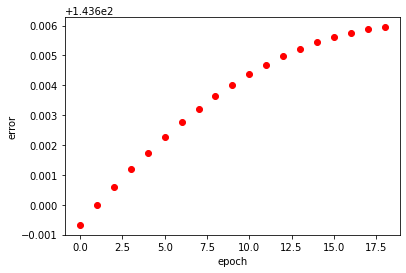

Plotting results


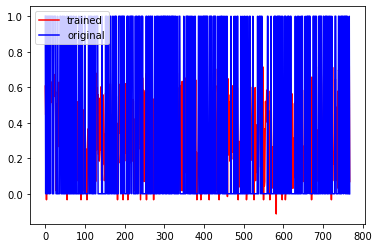

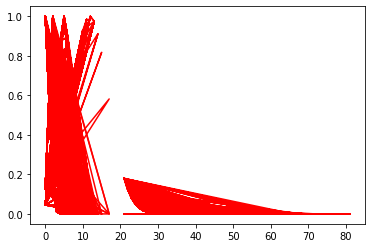

In [ ]:


mf = [[['gaussmf',{'mean':30,'sigma':10}],['gaussmf',{'mean':50,'sigma':10}],['gaussmf',{'mean':60.,'sigma':10.}]],
            [['gaussmf',{'mean':0,'sigma':1}],['gaussmf',{'mean':2.,'sigma':1.}],['gaussmf',{'mean':5,'sigma':2}],['gaussmf',{'mean':12,'sigma':5}]]]


mfc = MemFuncs(mf)
anf = ANFIS(X, Y, mfc)
anf.trainHybridJangOffLine(epochs=20)
print(round(anf.consequents[-1][0],6))
print(round(anf.consequents[-2][0],6))
print(round(anf.fittedValues[9][0],6))
if round(anf.consequents[-1][0],6) == -5.275538 and round(anf.consequents[-2][0],6) == -1.990703 and round(anf.fittedValues[9][0],6) == 0.002249:
	print('test is good')

print("Plotting errors")
anf.plotErrors()
print("Plotting results")
anf.plotResults()
anf.plotMF(X, 1)
